<a href="https://colab.research.google.com/github/brepowell/ML-Contest-Series/blob/main/MLSeriesSupervisedLearningTemplate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Breanna Powell

CSS 539

# To run:
Use an IDE that will allow you to open a Jupyter Notebook.

For example, use Anaconda Navigator to open Visual Studio Code.

You may need to select a kernel to run the program.

I used base(Python 3.10.9)

## Import Libraries

In [1]:
import pandas as pd
import matplotlib as plt

# These libraries are supposed to accelerate some operations
import numexpr
import bottleneck
pd.set_option("compute.use_bottleneck", False)
pd.set_option("compute.use_numexpr", False)

## Data Information

From:
https://data.london.gov.uk/dataset/smartmeter-energy-use-data-in-london-households

More Info:
https://innovation.ukpowernetworks.co.uk/projects/low-carbon-london

"Created 9 years ago, updated 2 years ago
Energy consumption readings for a sample of 5,567 London Households that took part in the UK Power Networks led Low Carbon London project between November 2011 and February 2014.

Readings were taken at half hourly intervals. The customers in the trial were recruited as a balanced sample representative of the Greater London population.

The dataset contains energy consumption, in kWh (per half hour), unique household identifier, date and time. The CSV file is around 10GB when unzipped and contains around 167million rows.

Within the data set are two groups of customers. The first is a sub-group, of approximately 1100 customers, who were subjected to Dynamic Time of Use (dToU) energy prices throughout the 2013 calendar year period. The tariff prices were given a day ahead via the Smart Meter IHD (In Home Display) or text message to mobile phone. Customers were issued High (67.20p/kWh), Low (3.99p/kWh) or normal (11.76p/kWh) price signals and the times of day these applied. The dates/times and the price signal schedule is availaible as part of this dataset. All non-Time of Use customers were on a flat rate tariff of 14.228pence/kWh.

The signals given were designed to be representative of the types of signal that may be used in the future to manage both high renewable generation (supply following) operation and also test the potential to use high price signals to reduce stress on local distribution grids during periods of stress.

The remaining sample of approximately 4500 customers energy consumption readings were not subject to the dToU tariff."


## Normalize

In [2]:
############################################
# This takes about 35 seconds to a minute  #
############################################

import pandas as pd

# These libraries are supposed to accelerate some operations
import numexpr
import bottleneck
pd.set_option("compute.use_bottleneck", False)
pd.set_option("compute.use_numexpr", False)

# Load
path = "Data/pickles/"
train_mean = pd.read_pickle("NormalizeMean.pkl")
train_std = pd.read_pickle("NormalizeStd.pkl")
test_df = pd.read_pickle(path + "data_noisy_gaussian_test.pkl") 

In [ ]:
# Normalize the noisy data
test_df = (test_df - train_mean) / train_std

In [4]:
# Save
path = "Data/pickles/"
test_df.to_pickle(path + "data_norm_test_gaussian.pkl")

# STEP 3: MODEL TRAINING & BUILDING


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import numexpr
import bottleneck

path = "Data/pickles/"
train_df = pd.read_pickle(path + "data_norm_training.pkl")
val_df = pd.read_pickle(path + "data_norm_validation.pkl")
test_df = pd.read_pickle(path + "data_norm_test_gaussian.pkl")

import pickle
with open('indeces.pkl', 'rb') as f:
    column_indices = pickle.load(f)

In [2]:
# https://www.tensorflow.org/tutorials/structured_data/time_series#data_windowing

class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [3]:
w1 = WindowGenerator(input_width=48, label_width=1, shift=48,
                     label_columns=['energy(kWh/hh)'])
w1

Total window size: 96
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [95]
Label column name(s): ['energy(kWh/hh)']

In [4]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['energy(kWh/hh)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['energy(kWh/hh)']

In [5]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [6]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 17)
Inputs shape: (3, 6, 17)
Labels shape: (3, 1, 1)


In [7]:
w2.example = example_inputs, example_labels

In [8]:
def plot(self, model=None, plot_col='energy(kWh/hh)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

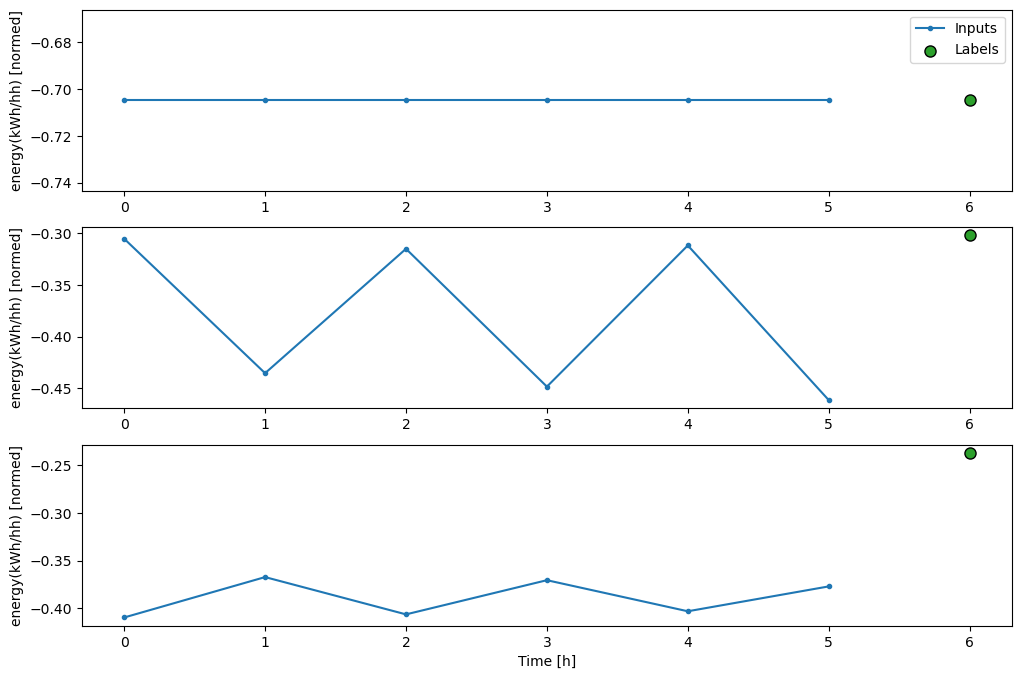

In [9]:
w2.plot()

In [10]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [11]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [12]:
##############################
# This takes about 2 minutes #
##############################

# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 17), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [13]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 17)
Labels shape (batch, time, features): (32, 1, 1)


## Single Time Step Prediction

In [14]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['energy(kWh/hh)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['energy(kWh/hh)']

In [15]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 17)
Labels shape (batch, time, features): (32, 1, 1)


## Baseline Model

In [16]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [17]:
baseline = Baseline(label_index=column_indices['energy(kWh/hh)'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)




 410197/1048857 [==========>...................] - ETA: 12:59 - loss: 0.4308 - mean_absolute_error: 0.2906

In [ ]:
from tensorflow import keras
path = "models/"

baseline.save(path + 'gaussian.keras')

In [ ]:
wide_window = WindowGenerator(
    input_width=48, label_width=48, shift=1,
    label_columns=['energy(kWh/hh)'])
wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['energy(kWh/hh)']

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 17)
Output shape: (32, 24, 1)


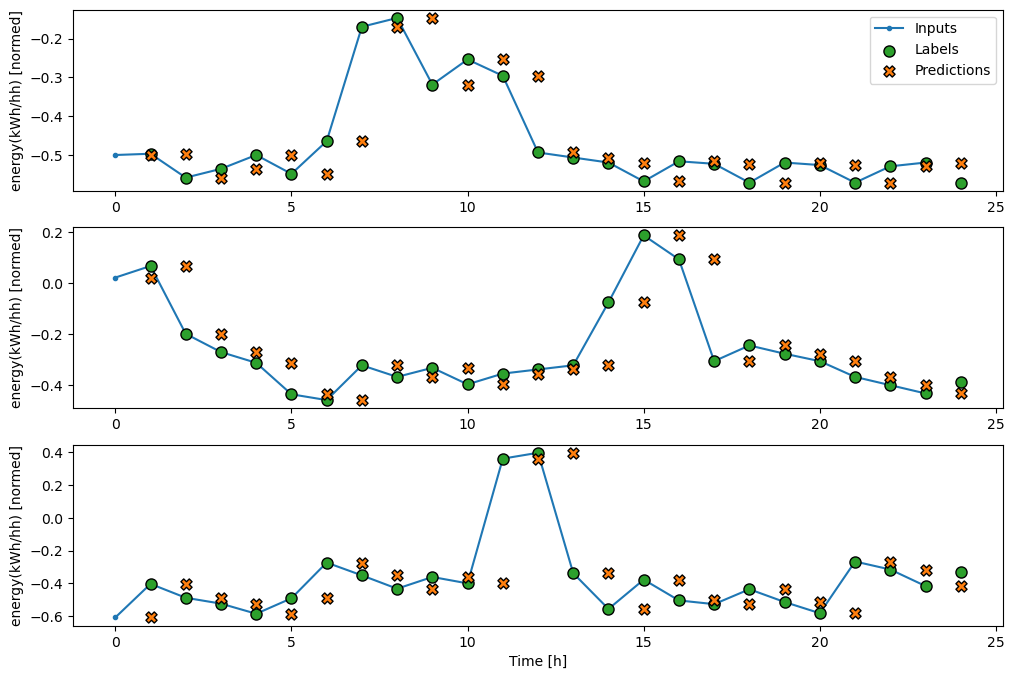

In [ ]:
wide_window.plot(baseline)

In [ ]:
# lstm_model = tf.keras.models.Sequential([
#     # Shape [batch, time, features] => [batch, time, lstm_units]
#     tf.keras.layers.LSTM(32, return_sequences=True),
#     # Shape => [batch, time, features]
#     tf.keras.layers.Dense(units=1)
# ])

In [ ]:
# print('Input shape:', wide_window.example[0].shape)
# print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 17)
Output shape: (32, 24, 1)


In [ ]:
# MAX_EPOCHS = 20

# def compile_and_fit(model, window, patience=2):
#   early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
#                                                     patience=patience,
#                                                     mode='min')

#   model.compile(loss=tf.keras.losses.MeanSquaredError(),
#                 optimizer=tf.keras.optimizers.Adam(),
#                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

#   history = model.fit(window.train, epochs=MAX_EPOCHS,
#                       validation_data=window.val,
#                       callbacks=[early_stopping])
#   return history

In [ ]:
# import IPython
# import IPython.display

# history = compile_and_fit(lstm_model, wide_window)

# IPython.display.clear_output()
# val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
# performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/20
 913667/3670997 [======>.......................] - ETA: 3:30:40 - loss: 0.3303 - mean_absolute_error: 0.2699

KeyboardInterrupt: 

In [ ]:
# wide_window.plot(lstm_model)

In [ ]:
# x = np.arange(len(performance))
# width = 0.3
# metric_name = 'mean_absolute_error'
# metric_index = lstm_model.metrics_names.index('mean_absolute_error')
# val_mae = [v[metric_index] for v in val_performance.values()]
# test_mae = [v[metric_index] for v in performance.values()]

# plt.ylabel('mean_absolute_error [energy, normalized]')
# plt.bar(x - 0.17, val_mae, width, label='Validation')
# plt.bar(x + 0.17, test_mae, width, label='Test')
# plt.xticks(ticks=x, labels=performance.keys(),
#            rotation=45)
# _ = plt.legend()

In [ ]:
# for name, value in performance.items():
#   print(f'{name:12s}: {value[1]:0.4f}')

In [ ]:
# lstm_model.save(path + 'lstm.keras')